In [1]:
%cd ..

/home/gianscarpe/dev/event-camera/src


In [3]:
from experimenting.dataset import DHPHeatmapDataset, get_dataloader
from experimenting.dataset.indexes import get_dataset_params
from matplotlib import pyplot as plt
import numpy as np
from albumentations import Compose, CenterCrop
from albumentations.pytorch import ToTensor
import torch
from importlib import reload  
from omegaconf import DictConfig

%matplotlib inline

In [4]:
def display(img):          
        fig, ax = plt.subplots(ncols=img.shape[0], nrows=1,                              
                               figsize=(20,20))                                                                                   
        for i in range(img.shape[0]):                                                                
            ax[i].imshow(img[i])                                                  
            ax[i].axis('off')
        plt.show()

In [5]:
def plot_2d(dvs_frame, sample_gt, sample_pred):
    " To plot image and 2D ground truth and prediction "
    plt.figure()
    plt.imshow(dvs_frame, cmap='gray')
    plt.plot(sample_gt[:,1], sample_gt[:,0], '.', c='red', label='gt')
    plt.plot(sample_pred[:,1], sample_pred[:,0], '.', c='blue', label='pred')
    plt.legend()

## 

In [6]:
# Augmentation
aug = Compose([CenterCrop(256, 256), ToTensor()])

In [32]:
data_dir = '/data/dhp19/time_count_dataset/movements_per_frame'
labels_dir = '/data/dhp19/time_count_dataset/labels'
test_subjects = [1, 2, 3, 4, 5]
cams = [2]

hparams = DictConfig({'data_dir': data_dir, 'save_split':False, 'labels_dir' : labels_dir, 'test_subjects':test_subjects, 'cams': cams})
params = get_dataset_params(hparams)

.npy|.mat


In [33]:
d = DHPHeatmapDataset(params['file_paths'], labels_dir, params['test_indexes'], transform=aug)
loader = get_dataloader(d, 32, 2)

In [34]:
batch = next(iter(loader))
x, y = batch

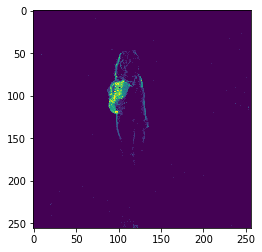

In [35]:
plt.imshow(x[1].squeeze())

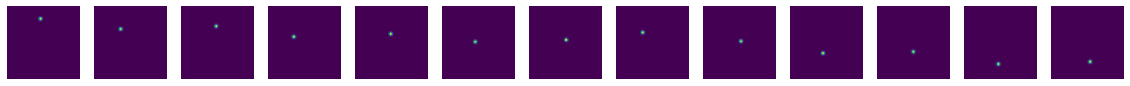

In [36]:
display(y[1].numpy())

## Loaded model for 2d heatmap prediction

In [37]:
import experimenting.models as models
import os
import experimenting.models.metrics as metrics
import experimenting.models.losses as losses
from experimenting.models.dsnt import average_loss
from experimenting.utils import get_joints_from_heatmap

exp_name = 'exps_unet_resnet34/exp_SGD_0.01_randomcrop_hflip_aug_05-20-08-45'
checkpoint_dir = f'/home/gianscarpe/dev/exps/timecount_pose/{exp_name}/checkpoints'
checkpoints = sorted(os.listdir(checkpoint_dir))
checkpoint_path = os.path.join(checkpoint_dir, checkpoints[0])
model = models.PoseEstimator.load_from_checkpoint(checkpoint_path)
model = model.eval()

In [38]:
loss = losses.HeatmapLoss('mask_mean')
mp = metrics.MPJPE(average_loss)

In [39]:
with torch.no_grad():
    preds = model(x)
gt_joints, _ = get_joints_from_heatmap(y)
p_joints, p_conf = get_joints_from_heatmap(preds)

In [47]:
mp(gt_joints, p_joints)

tensor(27.5304)

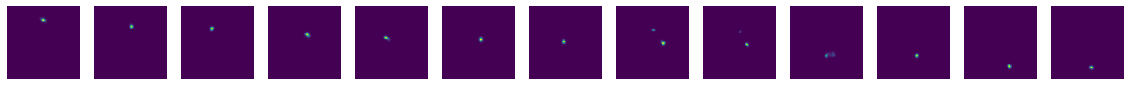

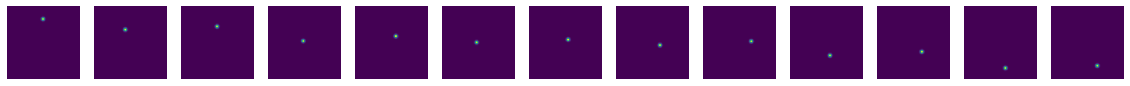

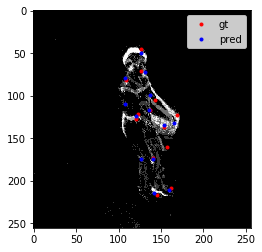

In [48]:
display(preds[2].numpy())
display(y[2].numpy())
plot_2d(x[2].squeeze(), gt_joints[2], p_joints[2])